# This notebook will help understand what are the effects of resolution, scale and noise on the wasserstein and the l2 metric

We will look at how increasing the resolution(number of bins) on the same area, increases the wasserstein distance. I would expect the distance to become smaller and to converge to some value.

## Some Extra functions and imports

In [1]:
import numpy as np
import ot
from ot.datasets import make_1D_gauss
import pandas as pd
import matplotlib.pyplot as plt
from utils.Visualizations import *
from ipywidgets import interact, interactive, fixed, interact_manual, FloatSlider
import ipywidgets as widgets
import seaborn as sns
from tqdm import tqdm
from scipy.stats import norm

No GPU/TPU found, falling back to CPU. (Set TF_CPP_MIN_LOG_LEVEL=0 and rerun for more info.)


In [2]:
def create_distribs_and_costs(res, noise, scale_parameter=1, distance_metric='L1'):
    X = np.linspace(0,scale_parameter,res)
    p = norm.pdf(X, scale_parameter * 0.35, scale_parameter * 0.1)
    p = p/p.sum()
    q = norm.pdf(X, scale_parameter * 0.65, scale_parameter * 0.1)
    q = q/q.sum()
    
    C = np.zeros([res, res], dtype=np.float64)
    if distance_metric == 'L1':
        dist = lambda a, b: abs(a - b)
    elif distance_metric == 'L2':
        dist = lambda a, b: (a - b) ** 2
    else:
        raise ValueError('Invalid distance metric. Must be either "L1" or "L2".')
    for it1 in range(res):
        for it2 in range(res):
            C[it1, it2] = dist(X[it1], X[it2])

    noise_p = np.random.normal(0, noise, res)
    noise_q = np.random.normal(0, noise, res)

    p_noised = p + noise_p
    q_noised = q + noise_q

    p_pos, p_neg = split_signed_measure(p_noised)
    q_pos, q_neg = split_signed_measure(q_noised)

    p_post = p_pos + q_neg
    q_post = p_neg + q_pos

    mean_distribs = (q_post.sum() + p_post.sum()) / 2
    p_post = p_post * (mean_distribs / p_post.sum())
    q_post = q_post * (mean_distribs / q_post.sum())
    
    return p, q, p_post, q_post, C
    # return p, q, p_post/p_post.sum(), q_post/q_post.sum(), C

In [86]:
def run_experiment_and_append(df, res, noise_param, scale_param, reg_m_param=10):
    results_classic = []
    results_noised = []
    ratios_emd = []
    results_linear = []
    results_linear_noised = []
    ratios_linear = []
    diff_classics = []
    diff_posts = []

    for i in range(100):
        p, q, p_post, q_post, C = create_distribs_and_costs(res, noise_param, scale_param)

        results_classic_add = calc_transport_pot_emd(p, q, C)[1]
        plan_noised, results_noised_add = calc_transport_pot_emd(p_post, q_post, C)

        results_classic.append(results_classic_add)
        results_noised.append(results_noised_add)
        ratios_emd.append(results_classic_add / results_noised_add)

        cumsum_p = np.cumsum(p)
        cumsum_q = np.cumsum(q)
        diff_classic = np.abs(cumsum_p - cumsum_q)
        diff_classics.append(diff_classic.sum())

        cumsum_p_post = np.cumsum(p_post)
        cumsum_q_post = np.cumsum(q_post)
        diff_post = np.abs(cumsum_p_post - cumsum_q_post)
        diff_posts.append(diff_post.sum())

        results_linear.append(np.linalg.norm(p - q))
        results_linear_noised.append(np.linalg.norm(p_post - q_post))
        ratios_linear.append(np.linalg.norm(p - q) / np.linalg.norm(p_post - q_post))

    # Create new row
    new_row = {
        'Res': res,
        'Noise_Param': noise_param,
        'Scale_Param': scale_param,
        'Distances_Classic': np.mean(results_classic),
        'Distances_Noised': np.mean(results_noised),
        'Cumsum_Classic': np.mean(diff_classics),
        'Cumsum_Noised': np.mean(diff_posts),
        'Ratios_emd_cumsum': np.mean(results_noised) / np.mean(diff_posts),
        'Ratios_EMD': np.mean(ratios_emd),
        'Distances_Linear': np.mean(results_linear),
        'Distances_Linear_Noised': np.mean(results_linear_noised),
        'Ratios_Linear': np.mean(ratios_linear)
    }

    # Append new row to DataFrame
    return df._append(new_row, ignore_index=True)

In [4]:
def run_experiment_and_append_unbalanced(df, res, noise_param, scale_param, reg_m_param=10):
    results_classic = []
    results_noised = []
    ratios_emd = []
    results_linear = []
    results_linear_noised = []
    ratios_linear = []

    for i in range(100):
        p, q, p_post, q_post, C = create_distribs_and_costs(res, noise_param, scale_param)

        results_classic_add = calc_transport_pot_emd(p, q, C)[1]
        plan_noised, log_noised = ot.unbalanced.mm_unbalanced(a=p_post, b=q_post, M=C, reg_m=reg_m_param, log=True)
        results_noised_add = log_noised['cost']
        # plan_noised, cost_noised = calc_transport_pot_emd(p_post, q_post, C)
        # results_noised_add = cost_noised

        results_classic.append(results_classic_add)
        results_noised.append(results_noised_add)
        ratios_emd.append(results_classic_add / results_noised_add)        

        results_linear.append(np.linalg.norm(p - q))
        results_linear_noised.append(np.linalg.norm(p_post - q_post))
        ratios_linear.append(np.linalg.norm(p - q) / np.linalg.norm(p_post - q_post))

    # Create new row
    new_row = {
        'Res': res,
        'Noise_Param': noise_param,
        'Scale_Param': scale_param,
        # 'Reg_M_Param': reg_m_param,
        'Distances_Classic': np.mean(results_classic),
        'Distances_Noised': np.mean(results_noised),
        'Cumsum_Classic': 0,  # TODO: implement
        'Cumsum_Noised:': 0,  # TODO: implement
        'Ratios_EMD': np.mean(ratios_emd),
        'Distances_Linear': np.mean(results_linear),
        'Distances_Linear_Noised': np.mean(results_linear_noised),
        'Ratios_Linear': np.mean(ratios_linear)
    }

    # Append new row to DataFrame
    return df._append(new_row, ignore_index=True)

## Running an experiment on a single measure

In [58]:
resolution = 500
noise_param = 1e-2
scale_param = 500
X = np.linspace(0,scale_param,resolution)

p = norm.pdf(X, scale_param * 0.25, scale_param * 0.05)
p = p / p.sum()
q = norm.pdf(X, scale_param * 0.75, scale_param * 0.05)
q = q / q.sum()

noise_p = np.random.normal(0, noise_param, resolution)
noise_q = np.random.normal(0, noise_param, resolution)

In [59]:
C = np.zeros([resolution,resolution],dtype=np.float64)
dist_f1 = lambda a,b : abs(a-b)
dist_f2 = lambda a,b : (a-b)**2
for it1 in range(resolution):
    for it2 in range(resolution):
        C[it1,it2] = dist_f1(X[it1],X[it2])

In [60]:
p_noised = p + noise_p
q_noised = q + noise_q

p_pos, p_neg = split_signed_measure(p_noised)
q_pos, q_neg = split_signed_measure(q_noised)

p_post = p_pos + q_neg
q_post = p_neg + q_pos

mean_distribs = (q_post.sum() + p_post.sum()) / 2
p_post = p_post * (mean_distribs / p_post.sum())
q_post = q_post * (mean_distribs / q_post.sum())

In [44]:
results_classic = calc_transport_pot_emd(p, q, C)[1]
results_noised = calc_transport_pot_emd(p_post, q_post, C)[1]

print('Results on classic EMD:', results_classic)
print('Results on noised:', results_noised)
print('Ratio:', results_classic/results_noised)

print('Results on normal linear:', np.linalg.norm(p-q))
print('Results on linear noised:', np.linalg.norm(p_post-q_post))
print('Ratio:', np.linalg.norm(p-q)/np.linalg.norm(p_post-q_post))

Results on classic EMD: 249.9999328737993
Results on noised: 257.794761851545
Ratio: 0.9697634314919306
Results on normal linear: 0.1503755984893435
Results on linear noised: 0.35748847947742457
Ratio: 0.4206446000977767


In [45]:
type(p)

numpy.ndarray

In [46]:
cumsum_p = np.cumsum(p)
cumsum_q = np.cumsum(q)
diff_classic = np.abs(cumsum_p - cumsum_q)

cumsum_p2 = np.cumsum(p_post)
cumsum_q2 = np.cumsum(q_post)
diff_post = np.abs(cumsum_p2 - cumsum_q2)

In [47]:
diff_post.sum()

257.27917232784165

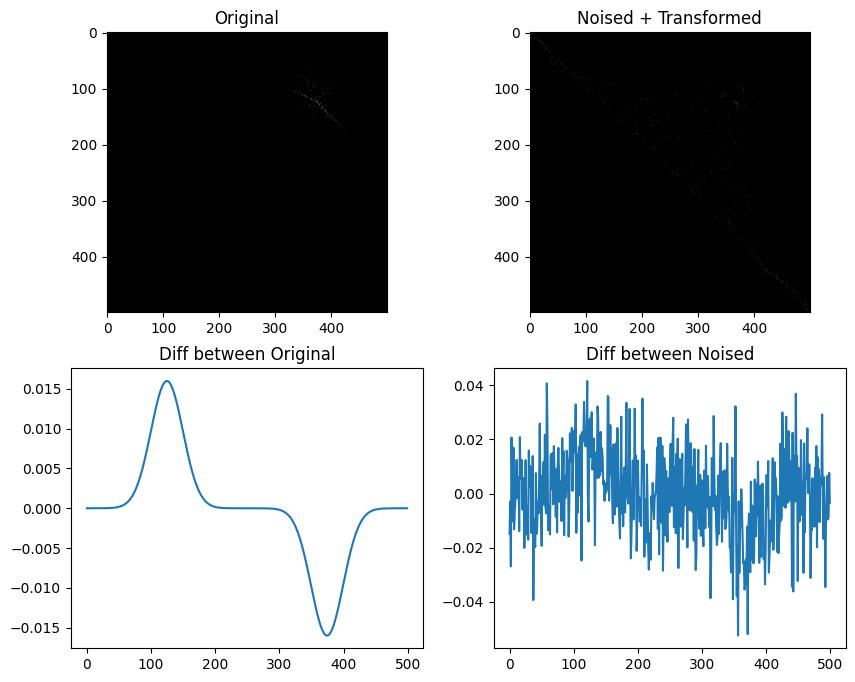

In [48]:
fig = plt.figure(figsize=(10,8))

fig.add_subplot(2,2,1)
plt.title('Original')
plt.imshow(ot.emd(a=p, b=q, M=C), cmap='gray')

fig.add_subplot(2,2,2)
plt.title('Noised + Transformed')
plt.imshow(calc_transport_pot_emd(p_post, q_post, C)[0], cmap='gray')

fig.add_subplot(2,2,3)
plt.title('Diff between Original')
plt.plot(p - q)

fig.add_subplot(2,2,4)
plt.title('Diff between Noised')
plt.plot(p_post - q_post)

In [ ]:
cumsum_p = np.cumsum(p_post)
cumsum_q = np.cumsum(q_post)
x_values = np.arange(1, resolution + 1)

plt.plot(x_values, cumsum_p, label='CDF of p')
plt.plot(x_values, cumsum_q, label='CDF of q')

plt.title('CDF')
plt.legend()

plt.show()

In [66]:
# We can calculate the sum of the cumsums since we are trying to find the integral, which will be the same whether we take the normal
# function or the inverse one.
diff = np.abs(cumsum_p - cumsum_q)
print(diff.sum())

304.8864593919256


## Normalizing the measures, noticing weird effects of noise after normalization

In [121]:
resolution =200
scale_param = 200
X = np.linspace(0,scale_param,resolution)

noises = np.linspace(start=1e-2,stop=1, num=20)
# noises = [1e-3]

# Initialize DataFrame
columns = ['Res', 'Noise_Param', 'Scale_Param', 'Distances_Classic', 'Distances_Noised', 
           'Cumsum_Classic', 'Cumsum_Noised', 'Ratios_emd_cumsum',
           'Ratios_EMD', 'Distances_Linear', 'Distances_Linear_Noised', 'Ratios_Linear']
df = pd.DataFrame(columns=columns)

In [122]:
noises

array([0.01      , 0.06210526, 0.11421053, 0.16631579, 0.21842105,
       0.27052632, 0.32263158, 0.37473684, 0.42684211, 0.47894737,
       0.53105263, 0.58315789, 0.63526316, 0.68736842, 0.73947368,
       0.79157895, 0.84368421, 0.89578947, 0.94789474, 1.        ])

In [123]:
for noise in tqdm(noises):
    df = run_experiment_and_append(df, res=resolution, noise_param=noise, scale_param=scale_param)

  0%|                                                                                                                                                                                                       | 0/20 [00:00<?, ?it/s]C:\Users\eriki\AppData\Local\Temp\ipykernel_34916\1910542008.py:52: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  return df._append(new_row, ignore_index=True)
100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:25<00:00,  1.29s/it]


In [124]:
df.head()

,Res,Noise_Param,Scale_Param,Distances_Classic,Distances_Noised,Cumsum_Classic,Cumsum_Noised,Ratios_emd_cumsum,Ratios_EMD,Distances_Linear,Distances_Linear_Noised,Ratios_Linear
0,200.0,0.010000,200.0,59.968073,63.102386,59.668233,62.786874,1.005025,0.970696,0.159291,0.255417,0.625083
1,200.0,0.062105,200.0,59.968073,98.274475,59.668233,97.783102,1.005025,0.746782,0.159291,1.247477,0.127961
2,200.0,0.114211,200.0,59.968073,164.031014,59.668233,163.210858,1.005025,0.449002,0.159291,2.279636,0.070030
3,200.0,0.166316,200.0,59.968073,214.186528,59.668233,213.115596,1.005025,0.310839,0.159291,3.327124,0.048004
4,200.0,0.218421,200.0,59.968073,281.026773,59.668233,279.621639,1.005025,0.256553,0.159291,4.370394,0.036535


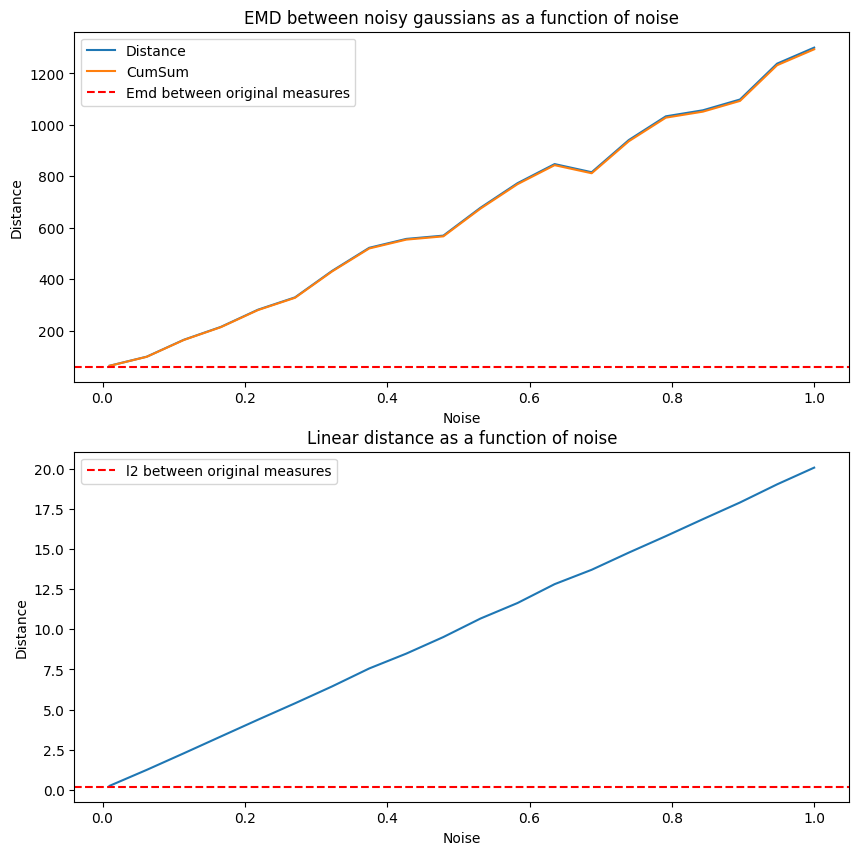

In [125]:
fig = plt.figure(figsize=(10,10))
fig.add_subplot(2,1,1)
plt.plot(df['Noise_Param'], df['Distances_Noised'], label='Distance')
plt.plot(df['Noise_Param'], df['Cumsum_Noised'], label='CumSum')
# plt.xscale('log')
plt.title('EMD between noisy gaussians as a function of noise')
plt.xlabel('Noise')
plt.ylabel('Distance')
plt.axhline(y=df['Distances_Classic'][0], color='r', linestyle='--', label='Emd between original measures')
plt.legend()

fig.add_subplot(2,1,2)
plt.plot(df['Noise_Param'], df['Distances_Linear_Noised'])
# plt.xscale('log')
plt.title('Linear distance as a function of noise')
plt.xlabel('Noise')
plt.ylabel('Distance')
plt.axhline(y=df['Distances_Linear'][0], color='r', linestyle='--', label='l2 between original measures')
plt.legend()
plt.show()

In [133]:
noise = np.array(df['Noise_Param'])
emd = np.array(df['Distances_Noised'])
lin = np.array(df['Distances_Linear_Noised'])

In [134]:
slope_emd, intercept_emd = np.polyfit(noise, emd, 1)
print('The intercept for emd is', intercept_emd, 'and the slope is', slope_emd)

The intercept for emd is 18.64596587313044 and the slope is 1251.5196666020493


In [135]:
slope_lin, intercept_lin = np.polyfit(noise, lin, 1)
print('The intercept for emd is', intercept_lin, 'and the slope is', slope_lin)

The intercept for emd is 0.002181617391223159 and the slope is 20.006619562165163


### If we normalize the intercept to 1, since we care about the precentage difference, we will get:

In [136]:
slope_emd, intercept_emd = np.polyfit(noise, emd, 1)
print('The intercept for emd is', 1, 'and the slope is', slope_emd/intercept_emd)

The intercept for emd is 1 and the slope is 67.12013070910623


In [137]:
slope_lin, intercept_lin = np.polyfit(noise, lin, 1)
print('The intercept for linear is', 1, 'and the slope is', slope_lin / intercept_lin)

The intercept for linear is 1 and the slope is 9170.544588915349


## Looking into the CDF

In [126]:
res = 200
noise_param = 1e-2
scale_param = 200
X = np.linspace(0,scale_param,res)

p, q, p_post, q_post, C = create_distribs_and_costs(res, noise_param, scale_param)

In [127]:
results_classic_add = calc_transport_pot_emd(p, q, C)[1]
plan_noised, results_noised_add = calc_transport_pot_emd(p_post, q_post, C)

In [128]:
cumsum_p = np.cumsum(p)
cumsum_q = np.cumsum(q)
diff_classic = np.abs(cumsum_p - cumsum_q)

cumsum_p_post = np.cumsum(p_post)
cumsum_q_post = np.cumsum(q_post)
diff_post = np.abs(cumsum_p_post - cumsum_q_post)

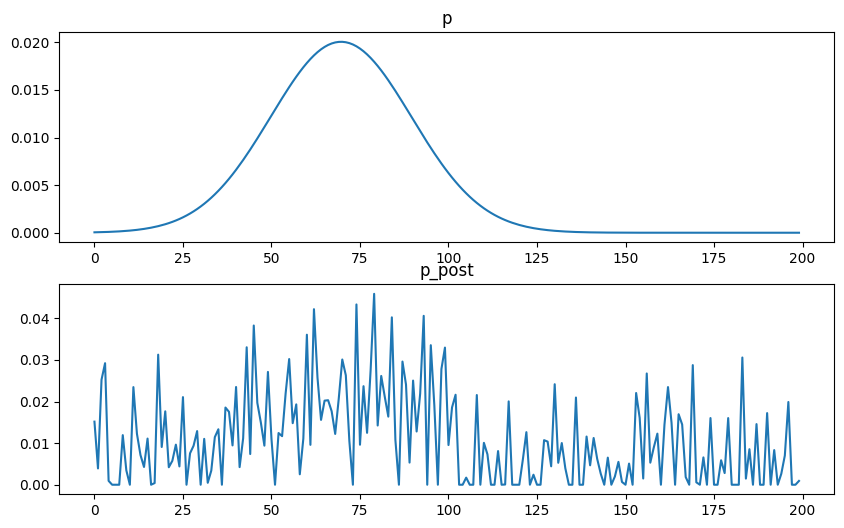

In [129]:
#looking into p
fig = plt.figure(figsize=(10, 6))

fig.add_subplot(2, 1, 1)
plt.title('p')
plt.plot(p)

fig.add_subplot(2, 1, 2)
plt.title('p_post')
plt.plot(p_post)

Calculating the ECDF(Empirical Cumulative Distribution Function)

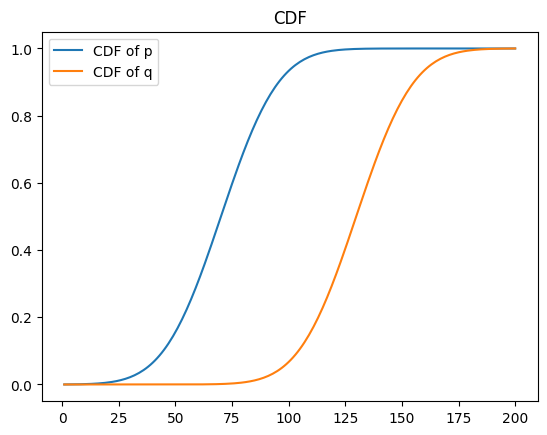

In [130]:
x_values = np.arange(1, res + 1)

plt.plot(x_values, cumsum_p, label='CDF of p')
plt.plot(x_values, cumsum_q, label='CDF of q')

plt.title('CDF')
plt.legend()

plt.show()

Noisy:

In [131]:
print('cumsum:', diff_post.sum())

print('emd:', calc_transport_pot_emd(p_post, q_post, C)[1])

print('The ratio for noisy', diff_post.sum() / calc_transport_pot_emd(p_post, q_post, C)[1])

cumsum: 64.07648090085388
emd: 64.39847326718973
The ratio for noisy 0.9950000000000015


Classic

In [132]:
print('cumsum:', diff_classic.sum())

print('emd:', calc_transport_pot_emd(p, q, C)[1])

print('the ratio is:', diff_classic.sum() / calc_transport_pot_emd(p,q,C)[1])

cumsum: 59.668232712640574
emd: 59.96807307803069
the ratio is: 0.9950000000000006
